C:\Users\jakob\AppData\Local\Temp\ipykernel_9100\1228861805.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ABKEl["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(ABKEl), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_9100\1228861805.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
C:\Users\jakob\AppData\Local\Temp\ipykernel_9100\1228861805.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_ABK = ABKEl["ABKEl"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykernel_9100\1228861805.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_E = Spotpris["Spotpris"].resample("M").mean()
C:\Users\jakob\AppData\Local\Temp\ipykerne

Summa kostnad i el 2023: 12038866.640975235
Justerad elkostnad simulering: 7522993.268472429


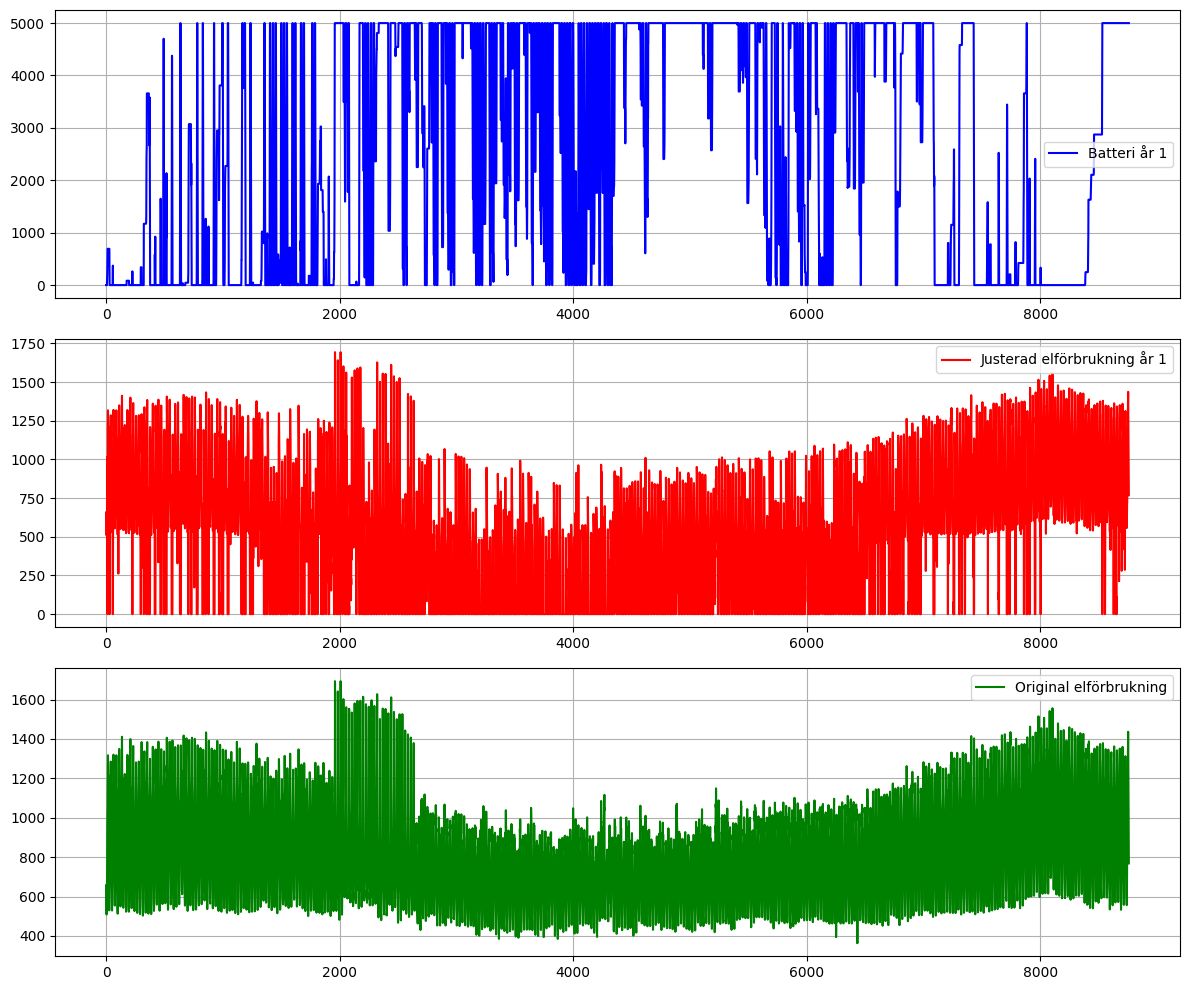

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in Excel-filer
Solprod = pd.read_excel("SolprodABK.xlsx")
ABKEl = pd.read_excel("ABKEL.xlsx", names=["ABKEl"])
Spotpris = pd.read_excel("Spotpris.xlsx", names=["Spotpris"])  # Namnge kolumnen korrekt

# Extrahera första kolumnen från respektive DataFrame
Sol = 0.8*Solprod.iloc[:, 0]  # Solel-produktion multipliceras med faktor 0.8 eftersom hela takytan inte kan användas

# Konvertera Spotpris till en lista för iteration
Spot_list = Spotpris["Spotpris"].tolist()
ABK_list = ABKEl["ABKEl"].tolist()

# Skapa tidsindex för ABKEl och Spotpris
ABKEl["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(ABKEl), freq="H")
ABKEl.set_index("Tid", inplace=True)

Spotpris["Tid"] = pd.date_range(start="2023-01-01 00:00", periods=len(Spotpris), freq="H")
Spotpris.set_index("Tid", inplace=True)

# Resampla till månatligt genomsnitt
monthly_avg_ABK = ABKEl["ABKEl"].resample("M").mean()
monthly_avg_E = Spotpris["Spotpris"].resample("M").mean()

# Beräkna överföringsavgift per månad
Spotpris["E"] = 4.004 + 0.0613 * Spotpris["Spotpris"]
monthly_avg_E = Spotpris["E"].resample("M").mean()

# Beräkna summa överföringsavgift för hela året
summaÖverfAvgift = (monthly_avg_E * monthly_avg_ABK).sum()
fastAbbKostnad = 795180.4
summaElnätskostnadKR = (summaÖverfAvgift / 100) + fastAbbKostnad

Spot_array = np.array(Spot_list)
ABK_array = np.array(ABK_list)

elhandelskostnad = (Spot_array * ABK_array).sum() / 100
energiskatt = (43.9 * ABK_array).sum() / 100

summaElKostnad = (summaElnätskostnadKR + elhandelskostnad + energiskatt) * 1.25

print("Summa kostnad i el 2023:", summaElKostnad)


# ----------------------- YEAR 1 SIMULATION -----------------------
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
maxFrånBatteri = 1500


elförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
original_consumption = ABKEl["ABKEl"].tolist()
# Convert ABK to list for original consumption

köptaTimmar = []  # Lista för köpta spotpriser och tid

for tid, sol, abk, spot in zip(Spotpris.index, Sol, ABK_list, Spot_list):  
    diff = abk - sol  # Skillnad mellan förbrukning och solproduktion

    if diff < 0:  
        # Om solproduktionen är större än förbrukningen, ladda batteriet istället för att spara negativa värden
        batteriKapacitet = min(batteriKapacitet - diff, batteriMaxKapacitet)  # -diff eftersom diff är negativ
        elförbrukning.append(0)  # Vi behöver inte köpa el
        köptaTimmar.append((tid,0))
    else:
        if spot <= 35 and sol > 0:
            if batteriKapacitet + sol >= 5000: 
                solÖver = (batteriKapacitet + sol) - 5000
                batteriKapacitet = min(batteriKapacitet + sol, batteriMaxKapacitet)
                elförbrukning.append(max(0, abk-solÖver))  
                köptaTimmar.append((tid,spot))
            else:
                batteriKapacitet = min(batteriKapacitet + sol, batteriMaxKapacitet)
                elförbrukning.append(abk)  
                köptaTimmar.append((tid, spot))
        elif 35 < spot < 100 and sol > 0:
            elförbrukning.append(diff)
            köptaTimmar.append((tid, spot))
        elif spot >= 100 and sol > 0:
            energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri)
            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, diff - energiFrånBatteri)
            elförbrukning.append(köpt_el)  
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
        elif sol == 0 and spot >= 100:
            energiFrånBatteri = min(batteriKapacitet, abk, maxFrånBatteri)
            batteriKapacitet -= energiFrånBatteri
            köpt_el = max(0, abk - energiFrånBatteri)
            elförbrukning.append(köpt_el)  
            köptaTimmar.append((tid, spot if köpt_el > 0 else 0))
        else:
            elförbrukning.append(abk)  
            köptaTimmar.append((tid, spot))


    battery_values.append(batteriKapacitet)

# Fyll på elförbrukningen om den är kortare än Spotpris.index
if len(elförbrukning) < len(Spotpris.index):
    elförbrukning.extend([0] * (len(Spotpris.index) - len(elförbrukning)))


# Skapa DataFrame med tid som index
köptaTimmar_df = pd.DataFrame(köptaTimmar, columns=["Tid", "Spotpris"])
köptaTimmar_df.set_index("Tid", inplace=True)

# Beräkna månatligt medelvärde för köpta spotpriser
monthly_avg_E_köpt = köptaTimmar_df["Spotpris"].resample("M").mean()

# Skapa DataFrame för den uppdaterade elförbrukningen
elförbrukning_df = pd.DataFrame({"Tid": Spotpris.index, "elförbrukning": elförbrukning})
elförbrukning_df.set_index("Tid", inplace=True)

# Beräkna månatligt medelvärde av den uppdaterade elförbrukningen
monthly_avg_elförbrukning = elförbrukning_df["elförbrukning"].resample("M").mean()

# Beräkna justerad överföringsavgift
summaJusteradÖverf = (monthly_avg_E_köpt * monthly_avg_elförbrukning).sum()

summaJusteradÖverfKR = (summaJusteradÖverf / 100) + fastAbbKostnad

# Filtrera elförbrukning endast för de köpta timmarna
elförbrukning_köpt = elförbrukning_df.loc[köptaTimmar_df.index]

# Beräkna elhandelskostnaden: Spotpris * elförbrukning
elhandelskostnad_köpt = (köptaTimmar_df["Spotpris"] * elförbrukning_köpt["elförbrukning"]).sum() / 100

# Beräkna den justerade energiskatten
total_elförbrukning = sum(elförbrukning)
JusteradEnergiskatt = (total_elförbrukning * 43.9) / 100

# Beräkna den justerade elkostnaden
summaJusteradElkostnad = 1.25 * (JusteradEnergiskatt + elhandelskostnad_köpt + summaJusteradÖverfKR)

print("Justerad elkostnad simulering:", summaJusteradElkostnad)

# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(3, 1, figsize=(12, 10))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(elförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[2].plot(original_consumption, label='Original elförbrukning', color='green')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()




--- År 1 Slut ---
Batterienergi kvar vid årets slut: 5000 kWh
Summa spotpris köpt el med batteri år 1: 4272392.982309011
Besparingar i spotpris år 1: 1416913.3177909907

--- År 2 Slut ---
Batterienergi kvar vid årets slut: 5000 kWh
Summa spotpris köpt el med batteri år 2: 3522332.2651829994
Besparingar i spotpris år 2: 2166974.034917002


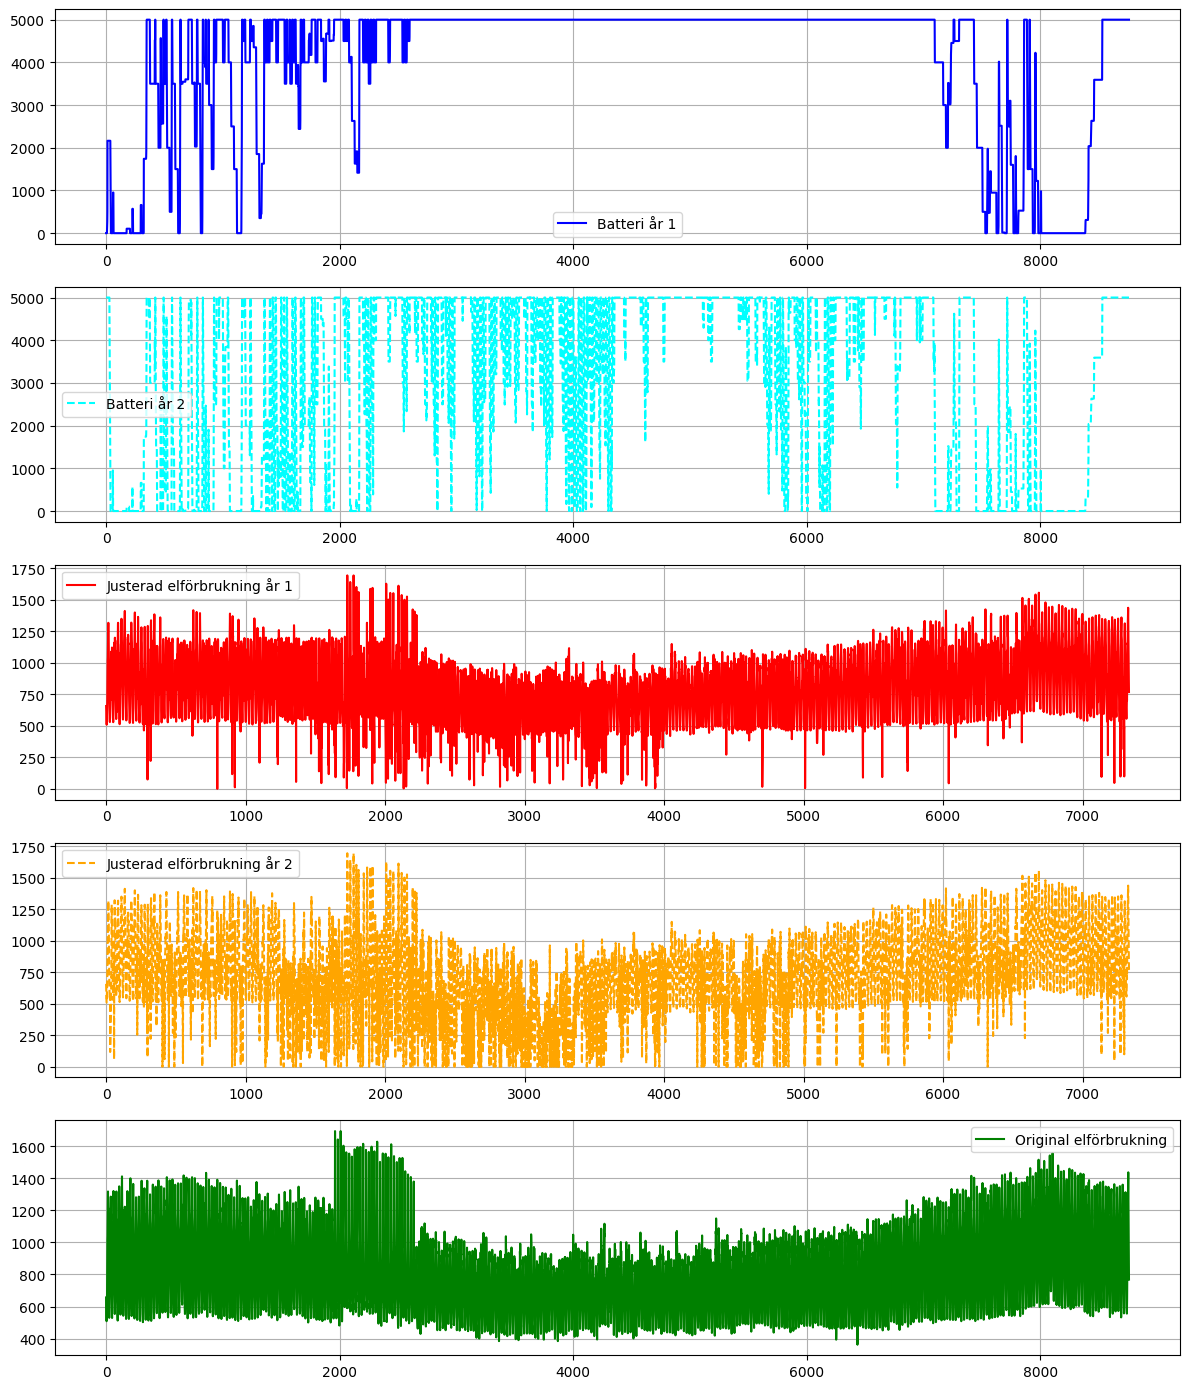

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Excel files
Solprod = pd.read_excel("SolprodABK.xlsx")
ABKEl = pd.read_excel("ABKEL.xlsx")
Spotpris = pd.read_excel("Spotpris.xlsx", names = ["Spotpris"])

# Extract first columns from each
Sol = Solprod.iloc[:, 0]  # Solar production
ABK = ABKEl.iloc[:, 0]    # Electricity consumption
Spot = Spotpris.iloc[:, 0]  # Spot price

# Initialize Battery and Costs
batteriKapacitet = 0.0  # Start with an empty battery
batteriMaxKapacitet = 5000  # Max battery capacity in kWh
maxFrånBatteri = 500

SummaSpotpris2023 = (Spot * ABK).sum() / 100
# Lists to store values for plotting
elförbrukning = []  # Adjusted electricity consumption for Year 1
battery_values = []  # Battery energy over time
original_consumption = ABK.tolist()  # Convert ABK to list for original consumption

# ----------------------- YEAR 1 SIMULATION -----------------------
KöptElSpotpris = 0.0  # Reset cost for Year 1

for sol, abk, spot in zip(Sol, ABK, Spot):
    diff = abk - sol  # Difference between consumption and solar production
    gräns = 1200

    # Update battery and electricity cost based on conditions
    if spot <= 35 and sol > 0:  # Store solar energy when spot price is low
        batteriKapacitet = min(batteriKapacitet + sol, batteriMaxKapacitet)
        KöptElSpotpris += spot * abk
        elförbrukning.append(abk)
    elif 35 < spot < 100 and sol > 0 and diff > 0:
        KöptElSpotpris += spot * diff
        elförbrukning.append(diff)
    elif spot >= 100 and sol > 0 and diff > 0 and batteriKapacitet > 0 and abk - gräns > 0:
        energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri)
        batteriKapacitet -= energiFrånBatteri
        KöptElSpotpris += (diff - energiFrånBatteri) * spot
        elförbrukning.append(diff - energiFrånBatteri)
    elif spot > 35 and sol > 0 and diff < 0:
        batteriKapacitet = min(batteriKapacitet + (-diff), batteriMaxKapacitet)
    elif sol == 0 and batteriKapacitet > 0 and spot >= 100 and abk -gräns > 0:
        energiFrånBatteri = min(batteriKapacitet, abk, maxFrånBatteri)
        batteriKapacitet -= energiFrånBatteri
        KöptElSpotpris += (abk - energiFrånBatteri) * spot
        elförbrukning.append(max(0, abk - energiFrånBatteri))
    else:
        KöptElSpotpris += abk * spot
        elförbrukning.append(abk)

    battery_values.append(batteriKapacitet)
    
    
    """
    # Update battery and electricity cost based on conditions
    if spot <= 35 and sol > 0:  # Store solar energy when spot price is low
        batteriKapacitet = min(batteriKapacitet + sol, batteriMaxKapacitet)
        KöptElSpotpris += spot * abk
        elförbrukning.append(abk)
    elif 35 < spot < 100 and sol > 0 and diff > 0:
        KöptElSpotpris += spot * diff
        elförbrukning.append(diff)
    elif spot >= 100 and sol > 0 and diff > 0 and batteriKapacitet > 0:
        energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri)
        batteriKapacitet -= energiFrånBatteri
        KöptElSpotpris += (diff - energiFrånBatteri) * spot
        elförbrukning.append(diff - energiFrånBatteri)
    elif spot > 35 and sol > 0 and diff < 0:
        batteriKapacitet = min(batteriKapacitet + (-diff), batteriMaxKapacitet)
    elif sol == 0 and batteriKapacitet > 0 and spot >= 100:
        energiFrånBatteri = min(batteriKapacitet, abk, maxFrånBatteri)
        batteriKapacitet -= energiFrånBatteri
        KöptElSpotpris += (abk - energiFrånBatteri) * spot
        elförbrukning.append(max(0, abk - energiFrånBatteri))
    else:
        KöptElSpotpris += abk * spot
        elförbrukning.append(abk)

    battery_values.append(batteriKapacitet)
"""
# Store battery energy left after year 1
battery_energy_end_of_year1 = batteriKapacitet
köptEliKr_år1 = KöptElSpotpris / 100
besparingar_år1 = SummaSpotpris2023 - köptEliKr_år1

print("\n--- År 1 Slut ---")
print("Batterienergi kvar vid årets slut:", battery_energy_end_of_year1, "kWh")
print("Summa spotpris köpt el med batteri år 1:", köptEliKr_år1)
print("Besparingar i spotpris år 1:", besparingar_år1)

# ----------------------- YEAR 2 SIMULATION -----------------------
batteriKapacitet = battery_energy_end_of_year1  # Start Year 2 with leftover battery energy
KöptElSpotpris = 0.0  # Reset for Year 2
elförbrukning_year2 = []
battery_values_year2 = []

for sol, abk, spot in zip(Sol, ABK, Spot):
    diff = abk - sol

    if spot <= 35 and sol > 0:
        batteriKapacitet = min(batteriKapacitet + sol, batteriMaxKapacitet)
        KöptElSpotpris += spot * abk
        elförbrukning_year2.append(abk)
    elif 35 < spot < 100 and sol > 0 and diff > 0:
        KöptElSpotpris += spot * diff
        elförbrukning_year2.append(diff)
    elif spot >= 100 and sol > 0 and diff > 0 and batteriKapacitet > 0:
        energiFrånBatteri = min(batteriKapacitet, diff, maxFrånBatteri)
        batteriKapacitet -= energiFrånBatteri
        KöptElSpotpris += (diff - energiFrånBatteri) * spot
        elförbrukning_year2.append(diff - energiFrånBatteri)
    elif spot > 35 and sol > 0 and diff < 0:
        batteriKapacitet = min(batteriKapacitet + (-diff), batteriMaxKapacitet)
    elif sol == 0 and batteriKapacitet > 0 and spot >= 100:
        energiFrånBatteri = min(batteriKapacitet, abk, maxFrånBatteri)
        batteriKapacitet -= energiFrånBatteri
        KöptElSpotpris += (abk - energiFrånBatteri) * spot
        elförbrukning_year2.append(max(0, abk - energiFrånBatteri))
    else:
        KöptElSpotpris += abk * spot
        elförbrukning_year2.append(abk)

    battery_values_year2.append(batteriKapacitet)

köptEliKr_år2 = KöptElSpotpris / 100
besparingar_år2 = SummaSpotpris2023 - köptEliKr_år2

print("\n--- År 2 Slut ---")
print("Batterienergi kvar vid årets slut:", batteriKapacitet, "kWh")
print("Summa spotpris köpt el med batteri år 2:", köptEliKr_år2)
print("Besparingar i spotpris år 2:", besparingar_år2)

# ----------------------- PLOTTING RESULTS -----------------------
fig, ax = plt.subplots(5, 1, figsize=(12, 14))

ax[0].plot(battery_values, label='Batteri år 1', color='blue')
ax[1].plot(battery_values_year2, label='Batteri år 2', color='cyan', linestyle='dashed')
ax[2].plot(elförbrukning, label='Justerad elförbrukning år 1', color='red')
ax[3].plot(elförbrukning_year2, label='Justerad elförbrukning år 2', color='orange', linestyle='dashed')
ax[4].plot(original_consumption, label='Original elförbrukning', color='green')

for a in ax:
    a.legend()
    a.grid(True)

plt.tight_layout()
plt.show()

